In [1]:
%load_ext autoreload
%autoreload

In [2]:
from curvemetrics.datafetcher import DataFetcher
from curvemetrics.metricsprocessor import MetricsProcessor
import timeit
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from web3 import Web3
import matplotlib.pyplot as plt
from curvemetrics.datahandler import DataHandler
import json
from curvemetrics.queries import queries
import ccxt
from dotenv import load_dotenv
import os
from scipy.optimize import minimize

In [3]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
pool = "0xceaf7747579696a2f0bb206a14210e3c9e6fb269" # Curve.fi Factory USD Metapool: wormhole v2 UST-3Pool
ust = "0xa693b19d2931d498c5b318df961919bb4aee87a5"
start = datetime.timestamp(datetime(2022, 5, 5))
end = datetime.timestamp(datetime(2022, 5, 15))
swaps_data = datahandler.get_swaps_data(pool, start, end)
swaps_data.head()

,id,timestamp,tx,pool_id,amountBought,amountSold,tokenBought,tokenSold,buyer,gasLimit,gasUsed,isUnderlying,block_gte,block_lt,block
0,0x984a6b74f8acc6321046980c6f92830cfca00d6b87ec...,1651710622,0x984a6b74f8acc6321046980c6f92830cfca00d6b87ec...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,7.568012e+03,7.574016e+03,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa693b19d2931d498c5b318df961919bb4aee87a5,0x81c46feca27b31f3adc2b91ee4be9717d1cd3dd7,434376,338889,1,14714080,14714090,14714088
1,0x35a6fb63b6d409f4547fa7ac08af449c27ee6486872a...,1651713816,0x35a6fb63b6d409f4547fa7ac08af449c27ee6486872a...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,9.997008e+01,1.000000e+02,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xee72b85e11d8a9c34c94e2630e41b8bc96cde270,573833,308664,1,14714310,14714320,14714315
2,0x34c8f372685a1f81494bc3ab73ed961556bbb62f1fd0...,1651715054,0x34c8f372685a1f81494bc3ab73ed961556bbb62f1fd0...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1.449549e+06,1.450000e+06,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xee72b85e11d8a9c34c94e2630e41b8bc96cde270,546097,291600,1,14714420,14714430,14714423
3,0x694a6a6d90a430f003e719af9c239c4d85155034a786...,1651717735,0x694a6a6d90a430f003e719af9c239c4d85155034a786...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,9.992210e-01,1.000000e+00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xb82b04f420d4bc501512013133ac7f2aca64a064,362224,252758,1,14714620,14714630,14714621
4,0xe70cf142a03b8a48cfee6abb4fcb4da797bb4147a010...,1651717735,0xe70cf142a03b8a48cfee6abb4fcb4da797bb4147a010...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,5.031008e+05,5.034950e+05,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa693b19d2931d498c5b318df961919bb4aee87a5,0x07c9aa769a0c86c69e9c1f4cdc19ef55e0fd1abe,383126,265106,1,14714620,14714630,14714621


In [27]:
freq = '1h'

ust_trades = swaps_data.copy()
ust_trades['Buy'] = (ust_trades['tokenBought'] == ust)
ust_trades['Sell'] = (ust_trades['tokenSold'] == ust)
ust_trades['timestamp'] = ust_trades['timestamp'].apply(datetime.fromtimestamp)
ust_trades = ust_trades.set_index('timestamp')
ust_trades = ust_trades.resample(freq).agg({'Buy': 'sum', 'Sell': 'sum'})

In [28]:
def rolling_apply(df, window=timedelta(days=1)):
    curr = df.index[0] + window
    end = df.index[-1]
    while curr <= end:
        print(curr-window, curr, end=" | ")
        pin = MetricsProcessor.pin_period(df.loc[curr-window:curr])
        print(pin)
        df.loc[curr, "PIN"] = pin
        curr += timedelta(hours=1) # TODO: Fix this with the actual step size  
    return df

In [29]:
foo = rolling_apply(ust_trades)
foo

2022-05-05 00:00:00 2022-05-06 00:00:00 | 

/root/curve-lp-metrics/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:863: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


[0.1        0.3        4.85714286 0.34       0.73428571]
0.31135531135531136
2022-05-05 01:00:00 2022-05-06 01:00:00 | 

/root/curve-lp-metrics/venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:863: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


[0.1        0.3        4.85714286 0.34       0.69428571]
0.31954887218045114
2022-05-05 02:00:00 2022-05-06 02:00:00 | [0.1        0.3        4.57142857 0.32       0.70285714]
0.30888030888030893
2022-05-05 03:00:00 2022-05-06 03:00:00 | [0.1        0.3        4.57142857 0.32       0.58285714]
0.33613445378151263
2022-05-05 04:00:00 2022-05-06 04:00:00 | [0.1        0.3        4.57142857 0.32       0.54285714]
0.3463203463203463
2022-05-05 05:00:00 2022-05-06 05:00:00 | [0.1        0.3        4.28571429 0.3        0.51142857]
0.34562211981566815
2022-05-05 06:00:00 2022-05-06 06:00:00 | [0.1        0.3        3.71428571 0.26       0.52857143]
0.32019704433497537
2022-05-05 07:00:00 2022-05-06 07:00:00 | [0.1        0.3        3.71428571 0.26       0.56857143]
0.30952380952380953
2022-05-05 08:00:00 2022-05-06 08:00:00 | [0.1        0.3        3.42857143 0.24       0.69714286]
0.26785714285714285
2022-05-05 09:00:00 2022-05-06 09:00:00 | [0.1        0.3        3.14285714 0.22       0.74

/root/curve-lp-metrics/curvemetrics/metricsprocessor.py:294: RuntimeWarning: overflow encountered in scalar power
  a5 = Xb**(-M) if M >= 0 else 0
/root/curve-lp-metrics/curvemetrics/metricsprocessor.py:297: RuntimeWarning: invalid value encountered in scalar multiply
  if any(x <= 0 for x in [Xb, Xs, mu+epsiB, mu+epsiS, a1*a2*a5, a1*a3*a4, a2*a3]):


[1.00000000e-01 3.00000000e-01 5.85714286e+02 4.10000000e+01
 9.65485714e+01]
0.2986509717082836
2022-05-09 23:00:00 2022-05-10 23:00:00 | [1.00000000e-01 3.00000000e-01 5.97428571e+02 4.18200000e+01
 9.33171429e+01]
0.3065622800844476
2022-05-10 00:00:00 2022-05-11 00:00:00 | [1.00000000e-01 3.00000000e-01 6.01142857e+02 4.20800000e+01
 9.10857143e+01]
0.31102175969725643
2022-05-10 01:00:00 2022-05-11 01:00:00 | [1.00000000e-01 3.00000000e-01 5.99428571e+02 4.19600000e+01
 8.78171429e+01]
0.3159543387247372
2022-05-10 02:00:00 2022-05-11 02:00:00 | [1.00e-01 3.00e-01 5.90e+02 4.13e+01 8.61e+01]
0.3165236051502146
2022-05-10 03:00:00 2022-05-11 03:00:00 | [1.00000000e-01 3.00000000e-01 5.75428571e+02 4.02800000e+01
 8.54171429e+01]
0.314029999688153
2022-05-10 04:00:00 2022-05-11 04:00:00 | [1.00000000e-01 3.00000000e-01 5.62857143e+02 3.94000000e+01
 8.42742857e+01]
0.3127679166798972
2022-05-10 05:00:00 2022-05-11 05:00:00 | [1.000e-01 3.000e-01 5.760e+02 4.032e+01 8.256e+01]
0.3191

/root/curve-lp-metrics/curvemetrics/metricsprocessor.py:293: RuntimeWarning: overflow encountered in scalar power
  a4 = Xs**(-M) if M >= 0 else 0


[1.00000000e-01 3.00000000e-01 6.48857143e+02 4.54200000e+01
 8.85342857e+01]
0.32632123458918877
2022-05-10 08:00:00 2022-05-11 08:00:00 | [1.00000000e-01 3.00000000e-01 6.76857143e+02 4.73800000e+01
 8.73742857e+01]
0.33434950743782993
2022-05-10 09:00:00 2022-05-11 09:00:00 | [1.00000000e-01 3.00000000e-01 7.14285714e+02 5.00000000e+01
 8.88514286e+01]
0.3396831435636838
2022-05-10 10:00:00 2022-05-11 10:00:00 | [1.00000000e-01 3.00000000e-01 7.82571429e+02 5.47800000e+01
 9.47228571e+01]
0.3435947614029806
2022-05-10 11:00:00 2022-05-11 11:00:00 | [1.00000000e-01 3.00000000e-01 8.48285714e+02 5.93800000e+01
 9.88714286e+01]
0.3489738827899105
2022-05-10 12:00:00 2022-05-11 12:00:00 | [1.00000000e-01 3.00000000e-01 9.10285714e+02 6.37200000e+01
 1.01211429e+02]
0.35563592525617843
2022-05-10 13:00:00 2022-05-11 13:00:00 | [1.00000000e-01 3.00000000e-01 9.36285714e+02 6.55400000e+01
 1.02791429e+02]
0.35741552690705236
2022-05-10 14:00:00 2022-05-11 14:00:00 | [1.00000000e-01 3.00000

,Buy,Sell,PIN
timestamp,,,
2022-05-05 00:00:00,0,1,NaN
2022-05-05 01:00:00,2,0,NaN
2022-05-05 02:00:00,0,3,NaN
2022-05-05 03:00:00,0,1,NaN
2022-05-05 04:00:00,1,1,NaN
...,...,...,...
2022-05-14 19:00:00,13,7,0.337212
2022-05-14 20:00:00,33,16,0.344527
2022-05-14 21:00:00,12,17,0.342420


<Axes: xlabel='timestamp'>

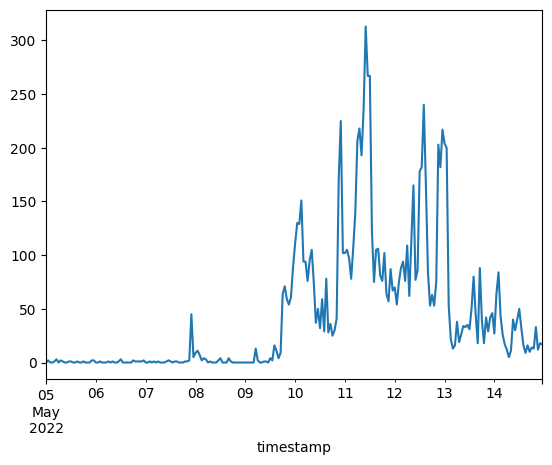

In [32]:
ust_trades['Buy'].plot()

In [35]:
token_ohlcv = datahandler.get_ohlcv_data(ust, start, end)
token_ohlcv.head()

,id,token_id,symbol,timestamp,open,high,low,close,volume
timestamp,,,,,,,,,
2022-05-05 00:00:00,1052472,0xa693b19d2931d498c5b318df961919bb4aee87a5,UST/USD,1651708800,1.000,1.0,0.999,0.999,108.80
2022-05-05 00:02:00,1052473,0xa693b19d2931d498c5b318df961919bb4aee87a5,UST/USD,1651708920,0.999,1.0,0.999,1.000,180.89
2022-05-05 00:05:00,1052474,0xa693b19d2931d498c5b318df961919bb4aee87a5,UST/USD,1651709100,0.999,1.0,0.999,1.000,74.07
2022-05-05 00:06:00,1052475,0xa693b19d2931d498c5b318df961919bb4aee87a5,UST/USD,1651709160,1.000,1.0,1.000,1.000,1.96
2022-05-05 00:07:00,1052476,0xa693b19d2931d498c5b318df961919bb4aee87a5,UST/USD,1651709220,0.999,1.0,0.999,1.000,278.31


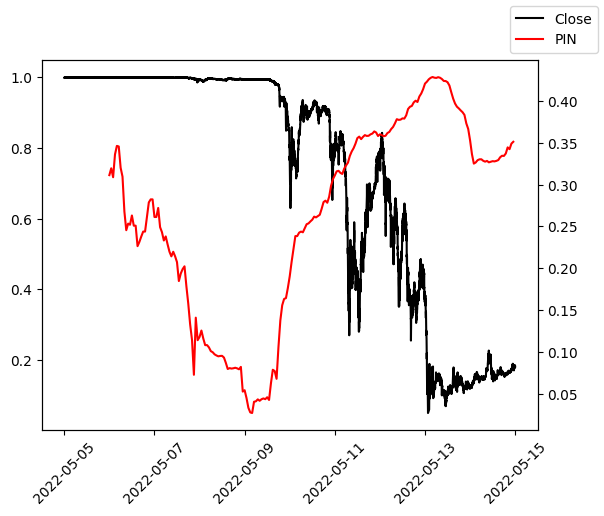

In [37]:
f, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax2.plot(foo.index, foo['PIN'], label='PIN', color='red')
ax1.plot(token_ohlcv.index, token_ohlcv['close'], label='Close', color='black')
f.legend()
ax1.tick_params(axis='x', rotation=45)
plt.show()

In [50]:
NAMES = [
    "Curve.fi ETH/frxETH",
    "Curve.fi Factory USD Metapool: Liquity",
    "Curve.fi Factory USD Metapool: Binance USD",
]
[k for k, v in pool_metadata.items() if v['name'] in NAMES]

['0xa1f8a6807c402e4a15ef4eba36528a3fed24e577',
 '0xed279fdd11ca84beef15af5d39bb4d4bee23f0ca',
 '0x4807862aa8b2bf68830e4c8dc86d0e9a998e085a']

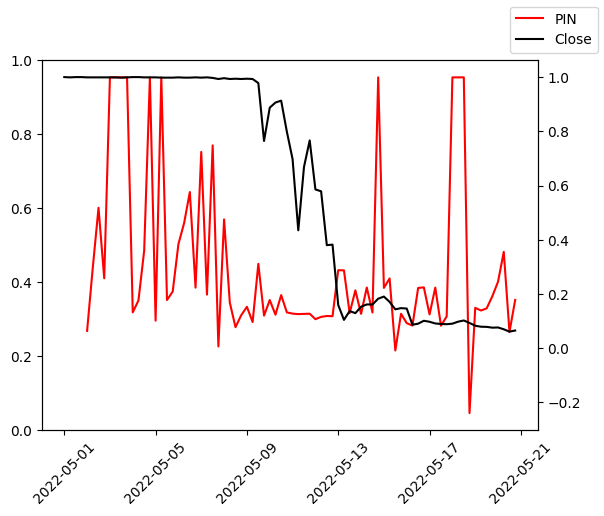

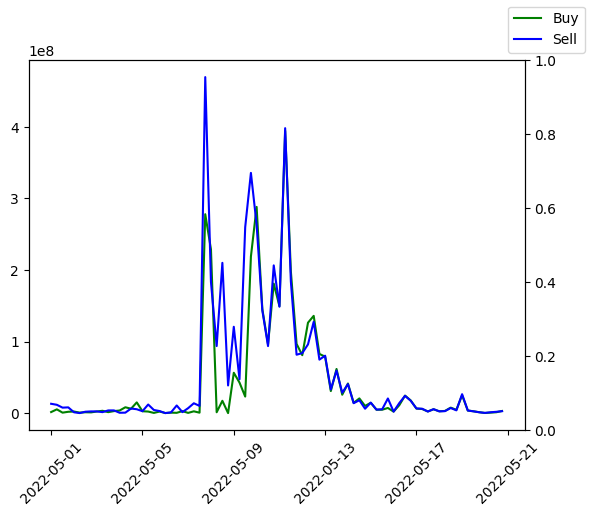

In [202]:
f, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(foo.index, foo['Buy'], label='Buy', color='green')
ax1.plot(foo.index, foo['Sell'], label='Sell', color='blue')
f.legend()
ax1.tick_params(axis='x', rotation=45)
plt.show()

In [ ]:
# def pin_likelihood_EHO(params, df): 
#     #initialize parameter values
#     alph, delt, mu, epsiB, epsiS = params

#     # Constraints from the model
#     if any(x < 0 for x in params) or alph > 1 or delt > 1:
#         return np.inf

#     def likelihood(row):
#         #number of buy- and sell-trades for the trading day
#         buy_s = row['Buy']
#         sell_s = row['Sell']

#         # Avoid invalid computations
#         if mu <= 0 or epsiB <= 0 or epsiS <= 0:
#             return np.inf

#         #compute values of interest for the log-likelihood function
#         M  = int(min(buy_s,sell_s)+max(buy_s,sell_s)/2)
#         Xs = epsiS/(mu+epsiS)
#         Xb = epsiB/(mu+epsiB)

#         a1 = np.exp(-mu)
#         a2 = Xs**(sell_s-M) if sell_s-M >= 0 else 0
#         a3 = Xb**(buy_s-M) if buy_s-M >= 0 else 0
#         a4 = Xs**(-M) if M >= 0 else 0
#         a5 = Xb**(-M) if M >= 0 else 0

#         # Avoid NaN and Inf in logarithmic operations
#         if any(x <= 0 for x in [Xb, Xs, mu+epsiB, mu+epsiS, a1*a2*a5, a1*a3*a4, a2*a3]):
#             return np.inf

#         part1 = -epsiB-epsiS+M*(np.log(Xb)+np.log(Xs))+buy_s*np.log(mu+epsiB)+sell_s*np.log(mu+epsiS)
#         part2 = np.log(alph*(1-delt)*a1*a2*a5+alph*delt*a1*a3*a4+(1-alph)*a2*a3)

#         return part1+part2

#     return -1 * df.apply(likelihood, axis=1).sum()